In [3]:
library(tidyverse,quietly = T)
library(caret,quietly = T)
library(AppliedPredictiveModeling,quietly = T)
library(Rtsne,quietly = T)
library(dplyr,quietly = T)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster,quietly = T)
library(fpc,quietly = T)
library(caret,quietly = T)
require(randomForest,quietly = T)
library(ROCR,quietly = T)
library(reshape,quietly = T)
library(ggpubr,quietly = T)

In [12]:
head(cancer_cases)

,Sample,CancerCellType,AlcoholAmount,CaseControl,ID,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,cg27532845,cg27544046,cg27571329,cg27582696,cg27592331,cg27619291,cg27625491,cg27631256,cg27652490,cg27662789
4350,Sample_4350,PC,2,1,PC_Pair_1,Never,0.03124907,28.51924,0.4788985,0.00000000,⋯,2.414362,2.651139,3.486998,4.583706,-2.919500,0.40259344,3.021267,-4.237509,4.150835,-0.57663078
4351,Sample_4351,PC,2,1,PC_Pair_2,Never,0.05779632,29.82310,0.1113933,0.11741328,⋯,1.905859,2.795076,4.766622,4.451506,-3.279560,0.80135911,2.805214,-10.561714,4.173721,-0.28770410
4353,Sample_4353,PC,1,1,PC_Pair_3,Never,0.10082223,30.05003,0.1844862,0.12306696,⋯,2.373926,3.322571,3.641761,4.523528,-1.889123,-0.25222105,3.081403,-4.467160,4.027842,-0.48581936
4355,Sample_4355,PC,2,1,PC_Pair_4,Former,0.06004972,27.90445,0.1091810,0.07194285,⋯,2.533471,3.329966,4.393810,4.027984,-2.519251,-0.04114089,3.641261,-5.127337,3.614891,-0.39961691
4358,Sample_4358,PC,1,1,PC_Pair_5,Never,0.11303621,26.42713,0.1657279,0.08150207,⋯,2.523112,3.920897,4.941176,3.398014,-2.868742,0.19374389,2.425730,-4.873014,3.655159,-0.01327332
4360,Sample_4360,PC,4,1,PC_Pair_6,Never,0.08055555,41.52421,0.1275946,0.09060549,⋯,1.526417,3.017570,4.289253,3.391646,-2.624313,0.72044895,3.010846,-2.894829,3.293960,0.28814321


[1]  863 2210

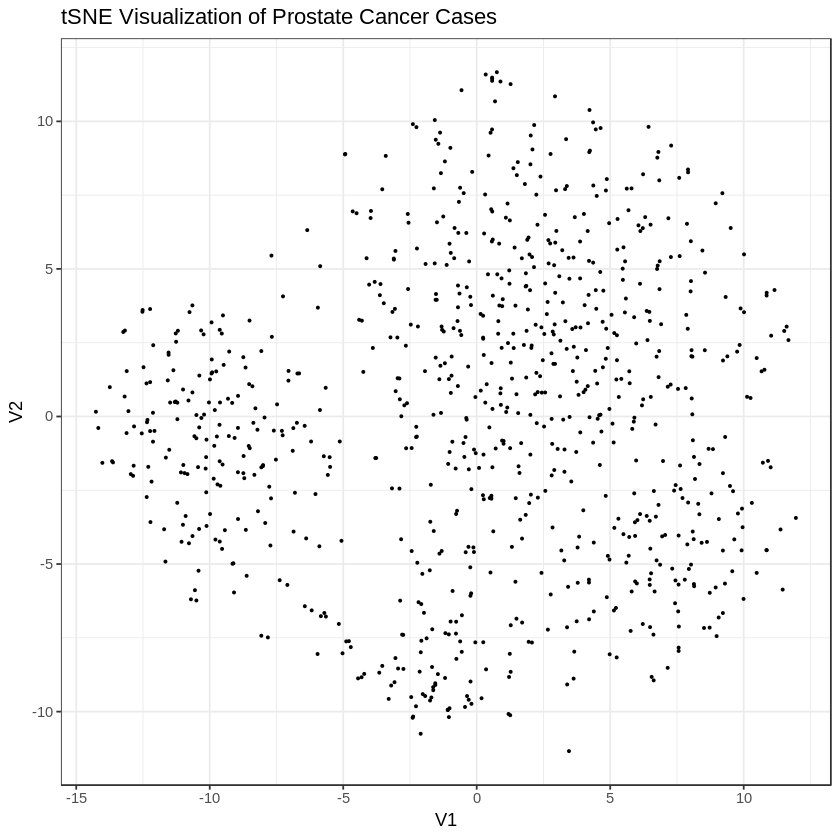

In [17]:
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_control <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("tSNE Visualization of Prostate Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

DBSCAN clustering for 863 objects.
Parameters: eps = 1.5, minPts = 15
The clustering contains 3 cluster(s) and 106 noise points.

  0   1   2   3 
106 474 116 167 

Available fields: cluster, eps, minPts

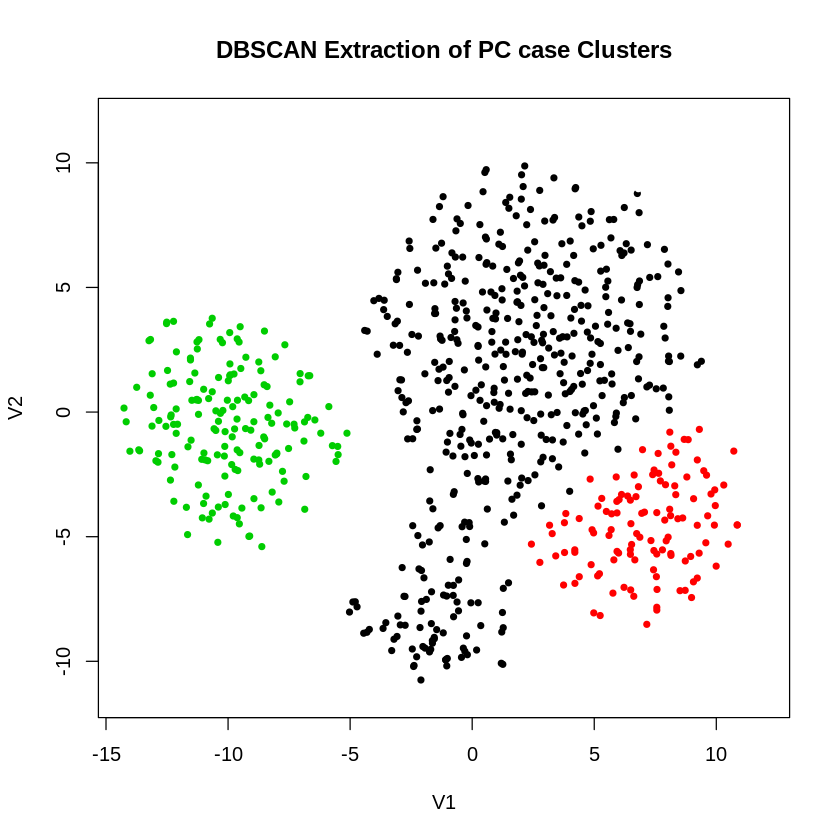

In [11]:
res <- dbscan::dbscan(d_tsne_3,eps = 1.5, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC cases")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

In [13]:
d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3) 

V1,V2,cluster,ID
-1.3959189,-4.6476141,1,PC_Pair_1
-14.2628937,0.1604518,3,PC_Pair_2
3.5794374,2.9629831,1,PC_Pair_3
5.9716910,-1.4912276,1,PC_Pair_4
6.3676282,3.5761073,1,PC_Pair_5
0.5680226,5.9295431,1,PC_Pair_6


In [14]:
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]



In [44]:
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")
cancer_cases_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==1,]
cancer_controls_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==0,]

In [45]:
cluster1_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster3$ID,]

## Cases in Cluster 1  and matching controls

In [46]:
head(cluster1_cases)
head(cluster1_controls)

,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4350,Sample_4350,PC,1,PC_Pair_1,2,Never,0.03124907,28.51924,0.4788985,0.00000000,⋯,1.2262072,0.8556876,1.0768256,-0.9672918,2.2953312,3.557203,1.5330157,-1.744068,0.5329113,0.968932779
4353,Sample_4353,PC,1,PC_Pair_3,1,Never,0.10082223,30.05003,0.1844862,0.12306696,⋯,1.6851114,0.1400600,0.6258309,-0.1437234,3.1403654,2.954671,1.9219780,-3.259399,0.1057944,0.002889846
4355,Sample_4355,PC,1,PC_Pair_4,2,Former,0.06004972,27.90445,0.1091810,0.07194285,⋯,2.4120595,0.5453855,0.7982160,-0.9299917,3.1558635,3.003048,0.5877212,-2.936598,0.8860706,0.326238155
4358,Sample_4358,PC,1,PC_Pair_5,1,Never,0.11303621,26.42713,0.1657279,0.08150207,⋯,2.2369826,0.5265385,0.8642715,-0.5512491,0.8518819,3.064723,-0.9403711,-3.147413,-3.2661796,-1.392128455
4360,Sample_4360,PC,1,PC_Pair_6,4,Never,0.08055555,41.52421,0.1275946,0.09060549,⋯,-0.4110105,0.4845656,0.7149950,-0.7424551,1.6664075,2.882332,1.9814976,-3.757477,0.7106879,0.289179001
4364,Sample_4364,PC,1,PC_Pair_8,1,Never,0.06817594,26.79123,0.3080299,0.15967438,⋯,2.3224883,0.5681482,0.4236015,0.8411062,1.1290718,3.737171,0.5636090,-1.874462,-2.6261978,-0.093592184


,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4349,Sample_4349,PC,0,PC_Pair_1,2,Never,0.02630550,23.80933,0.12668227,0.03316347,⋯,1.5457311,0.5469304,0.4910751,-1.7315195,0.8757137,3.082579,0.9575129,-3.435569,0.2141593,0.24575722
4354,Sample_4354,PC,0,PC_Pair_3,4,Never,0.05037990,25.58598,0.17959327,0.08882190,⋯,3.5004475,0.5856435,0.4211313,-1.4144366,3.2269144,3.245901,1.3239087,-3.986961,-1.7764825,-0.09075481
4356,Sample_4356,PC,0,PC_Pair_4,1,Never,0.11050807,30.67739,0.18013556,0.11107306,⋯,1.9433960,0.7128411,0.9361930,-0.1942653,3.0680312,3.059673,0.5933022,-3.817015,0.7982271,0.68652489
4357,Sample_4357,PC,0,PC_Pair_5,4,Former,0.04248149,29.10325,0.06717147,0.17098801,⋯,1.8049348,0.8185096,0.6725335,0.4012593,1.8933872,2.858437,1.1962743,-3.069210,0.7699756,-1.87176098
4359,Sample_4359,PC,0,PC_Pair_6,3,Former,0.09378724,28.26854,0.18097590,0.17949657,⋯,0.8035994,0.7665506,1.0434265,0.1836838,2.9495923,3.159290,1.6828115,-3.790084,-0.2694896,1.59295572
4363,Sample_4363,PC,0,PC_Pair_8,2,Current,0.05813113,26.67719,0.14146970,0.02430881,⋯,2.4150536,0.4420934,1.1291105,-0.5973236,3.8636715,3.376041,1.7665025,-3.717542,-2.5005084,-0.15991261


In [79]:
cluster1_data <- rbind(cluster1_cases,cluster1_controls)
cluster1_data <- subset(cluster1_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_data$CaseControl <- as.factor(cluster1_data$CaseControl)

cluster2_data <- rbind(cluster2_cases,cluster2_controls)
cluster2_data <- subset(cluster2_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster2_data$CaseControl <- as.factor(cluster2_data$CaseControl)


cluster3_data <- rbind(cluster3_cases,cluster3_controls)
cluster3_data <- subset(cluster3_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster3_data$CaseControl <- as.factor(cluster3_data$CaseControl)

In [80]:
head(cluster1_data)

,CaseControl,ACADM,ADGRD1,AGPAT4,ANKDD1B,ANKRD20A11P,ANKRD30B,ATP11A,C17orf98,C1orf86,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4350,1,0.7041977,2.748498,4.464242,-0.50715770,-0.1474585,-1.1737426,0.7528380,0.2624415,-0.02127049,⋯,1.2262072,0.8556876,1.0768256,-0.9672918,2.2953312,3.557203,1.5330157,-1.744068,0.5329113,0.968932779
4353,1,-1.4860289,3.089721,4.407704,-2.10061730,0.9917779,-0.3428516,0.1658720,0.4118937,-0.03323769,⋯,1.6851114,0.1400600,0.6258309,-0.1437234,3.1403654,2.954671,1.9219780,-3.259399,0.1057944,0.002889846
4355,1,1.0640191,2.772772,4.336310,0.06101848,-0.7394669,-1.5199955,-0.8040751,0.7426801,0.19885249,⋯,2.4120595,0.5453855,0.7982160,-0.9299917,3.1558635,3.003048,0.5877212,-2.936598,0.8860706,0.326238155
4358,1,-0.7797309,4.232276,4.375271,0.04588203,1.7076729,-2.3415597,-0.2065008,0.8482111,-0.27742300,⋯,2.2369826,0.5265385,0.8642715,-0.5512491,0.8518819,3.064723,-0.9403711,-3.147413,-3.2661796,-1.392128455
4360,1,-1.6417493,1.498153,4.223492,0.64674808,-0.4656938,-1.1586481,-0.6738730,0.3928819,0.12572105,⋯,-0.4110105,0.4845656,0.7149950,-0.7424551,1.6664075,2.882332,1.9814976,-3.757477,0.7106879,0.289179001
4364,1,0.1572353,2.428494,4.562383,0.41838765,-0.8953319,-1.1280747,1.1801281,0.7845050,1.18647453,⋯,2.3224883,0.5681482,0.4236015,0.8411062,1.1290718,3.737171,0.5636090,-1.874462,-2.6261978,-0.093592184


# Machine Learning algorithms for Classiciation

# 1. Partial Lease Squares Classification Algorithm

In [81]:
for (cluster_id in c(1,2,3)){
    
    myfolds <- createMultiFolds(df$CaseControl, k = 5, times = 10)
    control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")

    # Train PLS model
    mod1 <- train(CaseControl ~ ., data = df,
     method = "pls",
     metric = "Accuracy",
     tuneLength = 20,
     trControl = control,
     preProc = c("zv","center","scale"))
    # Check CV profile
    #plot(mod1)
    varImp(mod1)
}

ERROR: Error: $ operator is invalid for atomic vectors


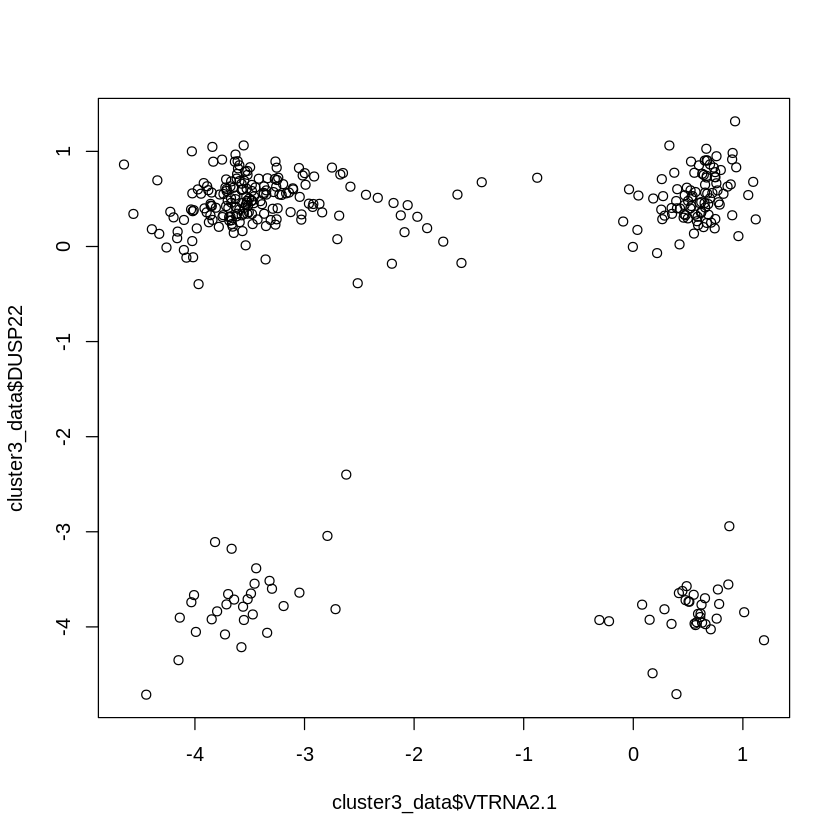

pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
DUSP22        100.00
VTRNA2.1       98.57
CYP4V2         28.13
LOC440910      25.11
LDHC           24.25
CCDC144NL      23.07
DOC2GP         22.83
LY6G5C         21.75
SIM2           20.99
RIMS4          20.23
LOC100128885   20.20
PSCA           19.60
CABLES1        18.61
C17orf98       18.11
C2orf69        18.07
IZUMO2         17.81
GSTM5          17.79
CTBP1.AS2      17.69
FGF12          17.18
LOC100506159   16.81